In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [38]:
import pandas as pd

class MnistDataset(torch.utils.data.Dataset):

    def __init__(self, file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data = pd.read_csv(file)
        print(data.shape)
        self.x = data[data.columns[1:]].values.reshape(-1, 28,28)
        self.y = data[data.columns[0]].values
        del data
        self.transform = transform

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].reshape(1,28,28).astype(np.float32), self.y[idx]

In [39]:
mnist_dataset = MnistDataset("../../239_all/239/6.Intro_to_NN/data/train.csv")

(42000, 785)


In [40]:
mnist_dataset

In [41]:
dataloader = DataLoader(mnist_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

## VAE

In [18]:
import sys
sys.path.append("./models/encoder")

In [97]:
from models.models import *

In [98]:
enc = Encoder()
dec = Decoder()

In [53]:
enc(torch.rand(10,1,28,28))[0].shape

dec.simple_forward(enc(torch.rand(10,1,28,28))[0]).shape

/home/anton/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


torch.Size([10, 1, 28, 28])

In [99]:
# model = VAE().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, sigma):
    MSE = torch.mean((x-recon_x)**2)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = - 0.5 * torch.sum(1 + sigma - mu.pow(2) - torch.exp(sigma))

    return MSE + KLD

In [100]:
enc = Encoder()
dec = Decoder()

In [101]:
opt = optim.Adam([x for x in enc.parameters()] + [x for x in dec.parameters()], lr =0.01)

In [102]:
losses = []

/home/anton/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


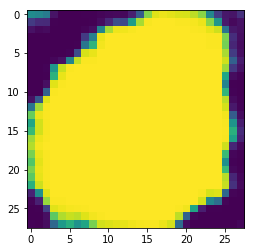

In [105]:
plt.imshow(dec(*enc(batch_x))[1][0].detach().numpy())

In [104]:
for i, (batch_x, _) in enumerate(dataloader):
    opt.zero_grad()
    mu, sigma = enc(batch_x)
    out = dec(mu, sigma)
    
    loss = loss_function(batch_x, out, mu, sigma)
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    if i%100 == 0:
        print(loss.item())

/home/anton/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


7356.08447265625
8285.6337890625
7499.52001953125


Process Process-42:
Process Process-43:
Process Process-44:
Process Process-41:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/site-packages/torc

KeyboardInterrupt: 

  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  